In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
### Square pulse function ###

### Give this function the parameters for a square pulse and it will return a square pulse experiment.

def Square_pulse_to_PE(backend_QC, qubit, drive_dur, drive_amp, drive_freq):
    
    from qiskit import pulse
    from qiskit.circuit import Gate

    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backend = provider.get_backend(backend_QC)

    envelope = pulse.Constant(duration=drive_dur,
                              amp=drive_amp,
                              name='excitation_pulse')
    
    with pulse.build(backend=backend) as single_pulse:
        drive_chan = pulse.drive_channel(qubit) 
        pulse.set_frequency(drive_freq, drive_chan)
        pulse.play(envelope, drive_chan)
        
    PE = QuantumCircuit(1, 1)
    pulse_gate = Gate("pulse_gate", 1, [])
    PE.append(pulse_gate, [0]) 
    PE.add_calibration(pulse_gate, [0], single_pulse) 
    PE.measure(0,0)
    
    return PE

### Further details ###

#Supply a backend quantum computer as a string..
#Supply the qubit that you wish to work on. This is an integer number starting from 0.
#Supply a drive duration in integer steps of dt = 0.222 ns. Must be at least 64 long, must be a multiple of 16.
#Supply an amplitude. Must be between 0 and 1.
#Supply a drive frequency in Hz.
#Returns a pulse experiment.

In [3]:
### Gaussian pulse function ###

### Give this function the parameters for a Gaussian pulse and it will return a Gaussian pulse experiment.

def Gaussian_pulse_to_PE(backend_QC, qubit, drive_dur, drive_sig, drive_amp, drive_freq):
    
    from qiskit import pulse
    from qiskit.circuit import Gate

    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backend = provider.get_backend(backend_QC)

    envelope = pulse.Gaussian(duration=drive_dur,
                              sigma=drive_sig,
                              amp=drive_amp,
                              name='excitation_pulse')
    
    with pulse.build(backend=backend) as single_pulse:
        drive_chan = pulse.drive_channel(qubit) 
        pulse.set_frequency(drive_freq, drive_chan)
        pulse.play(envelope, drive_chan)
        
    PE = QuantumCircuit(1, 1)
    pulse_gate = Gate("pulse_gate", 1, [])
    PE.append(pulse_gate, [0]) 
    PE.add_calibration(pulse_gate, [0], single_pulse) 
    PE.measure(0,0)
    
    return PE

### Further details ###

#Supply a backend quantum computer as a string.
#Supply the qubit that you wish to work on. This is an integer number starting from 0.
#Supply a drive duration in integer steps of dt = 0.222 ns. Must be at least 64 long, must be a multiple of 16.
#Supply the standard deviation of the Gaussian envelope.
#Supply an amplitude. Must be between 0 and 1.
#Supply a drive frequency in Hz.
#Returns a pulse experiment.

In [4]:
### Running pulse experiments function ###

### Give this function a pulse experiment or a list of pulse experiments and it will run them on a real quantum computer.

def Results_from_PE(backend_QC, PE, num_run, list_PE):
    
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backend = provider.get_backend(backend_QC)

    job = backend.run(PE, 
                      meas_level=2,
                      memory=True,
                      shots=num_run)
    
    results = job.result()
    
    if list_PE == True:
        
        exp = []
        
        for i in range(len(PE)):
            exp.append(results.get_memory(i))
        
        return exp
    
    else:
        return results.get_memory()
    
### Further details ###

#Supply a backend quantum computer as a string. Must match the backend used to create the pulse experiment.
#Supply a pulse experiment or a list of pulse experiments to run.
#Supply an integer telling the function how many times you want to run each pulse experiment.
#Supply a boolean. True if you want to run a list of pulse experiments, false if you want to run a single pulse experiment.
#Returns a list (or list of lists) of strings. Each string is either '0' og '1' depending on the qubit state after measurement.

#NB! You can run a list of at most 100 pulse experiments at a time.

In [5]:
### Example: Send a single pulse with a square envelope ###

#Parameters
backend_QC = 'ibmq_belem'
qubit = 0
drive_dur = 128 
drive_amp = 0.05 
drive_freq = 5.09*1e9
num_run = 1000

#Send pulse
PE = Square_pulse_to_PE(backend_QC, qubit, drive_dur, drive_amp, drive_freq)
results = Results_from_PE(backend_QC, PE, num_run, False)

#Print results
results = [int(x) for x in results]
print(f"On average, the state of our qubit after the experiment was {np.mean(results)}.")

On average, the state of our qubit after the experiment was 0.225.


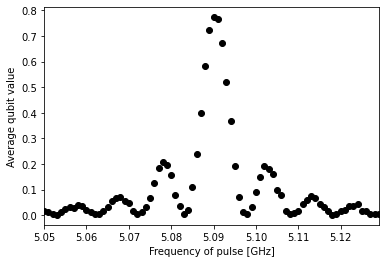

In [6]:
### Example: Frequency sweeping with square envelopes ###

#Parameters
backend_QC = 'ibmq_belem'
qubit = 0
drive_dur = 480 
drive_amp = 0.05 
num_run = 1000
frequencies_Hz = np.arange(5.05*1e9, 5.13*1e9, 1e6)

#For-loop different frequencies
freq_sweep_PE_list = []

for drive_freq in frequencies_Hz:
    PE = Square_pulse_to_PE(backend_QC, qubit, drive_dur, drive_amp, drive_freq)
    freq_sweep_PE_list.append(PE)

#Send pulse
results = Results_from_PE(backend_QC, freq_sweep_PE_list, num_run, True)

#Plot results
avg_qubit = []

for i in range(len(results)):
    qubit_states = [int(x) for x in results[i]]
    qubit_states_avg = np.mean(qubit_states)
    avg_qubit.append(qubit_states_avg)

import matplotlib.pyplot as plt

plt.scatter(frequencies_Hz/1e9, avg_qubit, color='black')
plt.xlim([min(frequencies_Hz/1e9), max(frequencies_Hz/1e9)])
plt.xlabel("Frequency of pulse [GHz]")
plt.ylabel("Average qubit value")
plt.show()

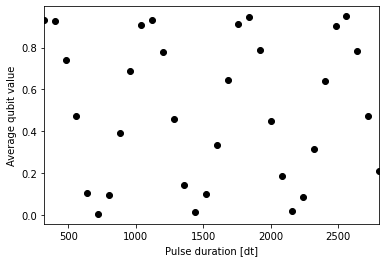

In [7]:
### Example: Rabi experiment with square envelopes ###

#Parameters
backend_QC = 'ibmq_belem'
qubit = 0
drive_amp = 0.05 
drive_freq = 5.09*1e9
num_run = 1000
drive_dur_list = np.arange(20*16, 180*16, 5*16).tolist()

#For-loop different durations
rabi_PE_list = []

for drive_dur in drive_dur_list:
    PE = Square_pulse_to_PE(backend_QC, qubit, drive_dur, drive_amp, drive_freq)
    rabi_PE_list.append(PE)

#Send pulse
results = Results_from_PE(backend_QC, rabi_PE_list, num_run, True)

#Plot results
avg_qubit = []

for i in range(len(results)):
    qubit_states = [int(x) for x in results[i]]
    qubit_states_avg = np.mean(qubit_states)
    avg_qubit.append(qubit_states_avg)

import matplotlib.pyplot as plt

plt.scatter(drive_dur_list, avg_qubit, color='black')
plt.xlim([min(drive_dur_list), max(drive_dur_list)])
plt.xlabel("Pulse duration [dt]")
plt.ylabel("Average qubit value")
plt.show()

In [ ]:
### Example: Send a single pulse with a Gaussian envelope ###

#Parameters
backend_QC = 'ibmq_belem'
qubit = 0
drive_dur = 128 
drive_sig = drive_dur/5 
drive_amp = 0.05 
drive_freq = 5.09*1e9 
num_run = 1000

#Send pulse
PE = Gaussian_pulse_to_PE(backend_QC, qubit, drive_dur, drive_sig, drive_amp, drive_freq)
results = Results_from_PE(backend_QC, PE, num_run, False)

#Print results
results = [int(x) for x in results]
print(f"On average, the state of our qubit after the experiment was {np.mean(results)}.")

In [ ]:
### Example: Frequency sweeping with Gaussian envelopes ###

#Parameters
backend_QC = 'ibmq_belem'
qubit = 0
drive_dur = 480
drive_sig = drive_dur/5
drive_amp = 0.05 
num_run = 1000
frequencies_Hz = np.arange(5.05*1e9, 5.13*1e9, 1e6)

#For-loop different frequencies
freq_sweep_PE_list = []

for drive_freq in frequencies_Hz:
    PE = Gaussian_pulse_to_PE(backend_QC, qubit, drive_dur, drive_sig, drive_amp, drive_freq)
    freq_sweep_PE_list.append(PE)

#Send pulse
results = Results_from_PE(backend_QC, freq_sweep_PE_list, num_run, True)

#Plot results
avg_qubit = []

for i in range(len(results)):
    qubit_states = [int(x) for x in results[i]]
    qubit_states_avg = np.mean(qubit_states)
    avg_qubit.append(qubit_states_avg)

import matplotlib.pyplot as plt

plt.scatter(frequencies_Hz/1e9, avg_qubit, color='black')
plt.xlim([min(frequencies_Hz/1e9), max(frequencies_Hz/1e9)])
plt.xlabel("Frequency of pulse [GHz]")
plt.ylabel("Average qubit value")
plt.show()

In [ ]:
### Example: Rabi experiment with Gaussian envelopes ###

#Parameters
backend_QC = 'ibmq_belem'
qubit = 0
drive_amp = 0.05 
drive_freq = 5.09*1e9
num_run = 1000
drive_dur_list = np.arange(20*16, 180*16, 5*16).tolist()

#For-loop different durations
rabi_PE_list = []

for drive_dur in drive_dur_list:
    
    drive_sig = drive_dur/5
    
    PE = Gaussian_pulse_to_PE(backend_QC, qubit, drive_dur, drive_sig, drive_amp, drive_freq)
    rabi_PE_list.append(PE)

#Send pulse
results = Results_from_PE(backend_QC, rabi_PE_list, num_run, True)

#Plot results
avg_qubit = []

for i in range(len(results)):
    qubit_states = [int(x) for x in results[i]]
    qubit_states_avg = np.mean(qubit_states)
    avg_qubit.append(qubit_states_avg)

import matplotlib.pyplot as plt

plt.scatter(drive_dur_list, avg_qubit, color='black')
plt.xlim([min(drive_dur_list), max(drive_dur_list)])
plt.xlabel("Pulse duration [dt]")
plt.ylabel("Average qubit value")
plt.show()